In [1]:
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

Using TensorFlow backend.
/home/yicong/anaconda3/envs/Standard_ML_Dev/lib/python3.5/site-packages/fix_yahoo_finance/__init__.py:43: DeprecationWarning: 
    Auto-overriding of pandas_datareader's get_data_yahoo() is deprecated and no longer available.
    Use pdr_override() to explicitly override it.
  DeprecationWarning)


In [2]:
start_date = "2013-01-01"
end_date = "2017-11-02"

data_AAPL = pdr.get_data_yahoo("FB", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 downloaded

In [3]:
data_AAPL_close = (data_AAPL['Close'].values.astype('float32'))
print(data_AAPL_close)

[  28.           27.77000046   28.76000023 ...,  180.05999756  182.66000366
  178.91999817]


In [4]:
import numpy as np
tar = np.divide(np.diff(data_AAPL_close), data_AAPL_close[:-1])
target = []
for i in tar:
#     if i>=0.02:
#         target.append(6)
#     elif i>=0.008 and i<0.02:
#         target.append(5)
#     elif i>=0.001 and i<0.008:
#         target.append(4)
#     elif i<= -0.02 :
#         target.append(0)
#     elif i>-0.02 and i<=-0.008:
#         target.append(1)
#     elif i>-0.008 and i<-0.001:
#         target.append(2)
    if i >0:
        target.append(1)
    else:
        target.append(0)
        
print(tar)

# Show target distribution
for i in range(7):
    print(target.count(i))
from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(sparse=False)
# target=np.array(target).reshape(-1,1)
# enc.fit(target)
# target = enc.transform(target)

[-0.00821427  0.03564997  0.02294853 ...,  0.00105633  0.01443967
 -0.02047523]
560
659
0
0
0
0
0


/home/yicong/anaconda3/envs/Standard_ML_Dev/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yicong/anaconda3/envs/Standard_ML_Dev/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [33]:
number_of_stock = 1
length = len(data_AAPL_close)-1
prices = np.reshape(data_AAPL_close[:-1], (length,number_of_stock))
print(prices)
prices.shape

[[  28.        ]
 [  27.77000046]
 [  28.76000023]
 ..., 
 [ 179.86999512]
 [ 180.05999756]
 [ 182.66000366]]


(1219, 1)

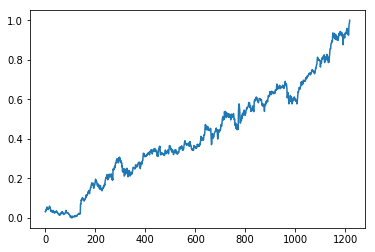

[[ 0.03192288]
 [ 0.03048322]
 [ 0.03668001]
 ..., 
 [ 0.9825362 ]
 [ 0.98372555]
 [ 1.        ]]


In [34]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
prices = scaler.fit_transform(prices)

plt.plot(prices)
plt.show()
print(prices)

In [35]:
train_size = int(len(prices) * 0.80)
test_size = len(prices) - train_size
train, test = prices[0:train_size,:], prices[train_size:len(prices),:]
print(len(train), len(test))

975 244


In [36]:
# # convert an array of values into a dataset matrix
# def create_dataset(dataset, look_back=1):
# 	dataX, dataY = [], []
# 	for i in range(len(dataset)-look_back-1):
# 		a = dataset[i:(i+look_back), :]
# 		dataX.append(a)
# 		dataY.append(dataset[i + look_back, :])
# 	return np.array(dataX), np.array(dataY)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(target[i + look_back])
    return np.array(dataX), np.array(dataY)

In [37]:
# reshape into X=t and Y=t+1
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], look_back, train.shape[1]))
testX = np.reshape(testX, (testX.shape[0], look_back, test.shape[1]))

print(trainY.shape)
print(trainX.shape)

(959,)
(959, 15, 1)


In [38]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, activation = 'sigmoid', input_shape=(look_back, number_of_stock)))
# model.add(LSTM(100))
# model.add(Dropout(0.1))
# model.add(LSTM(100, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#Step 2 Build Model

In [30]:
from keras.callbacks import ModelCheckpoint
epochs = 1500
batch_size = 1000

# model.load_weights('saved_models/weights.test_run')
checkpointer = ModelCheckpoint(filepath='saved_models/weights.test_run.hdf5', 
                                   verbose=1, save_best_only=True)

model.fit(trainX, trainY, nb_epoch=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[checkpointer])

Train on 863 samples, validate on 96 samples
Epoch 1/1500
Epoch 00000: val_loss improved from inf to 0.68492, saving model to saved_models/weights.test_run.hdf5
863/863 [==============================] - 0s - loss: 0.6911 - acc: 0.5319 - val_loss: 0.6849 - val_acc: 0.5729
Epoch 2/1500
Epoch 00001: val_loss improved from 0.68492 to 0.68492, saving model to saved_models/weights.test_run.hdf5
863/863 [==============================] - 0s - loss: 0.6911 - acc: 0.5319 - val_loss: 0.6849 - val_acc: 0.5729
Epoch 3/1500
Epoch 00002: val_loss improved from 0.68492 to 0.68491, saving model to saved_models/weights.test_run.hdf5
863/863 [==============================] - 0s - loss: 0.6911 - acc: 0.5319 - val_loss: 0.6849 - val_acc: 0.5729
Epoch 4/1500
Epoch 00003: val_loss improved from 0.68491 to 0.68491, saving model to saved_models/weights.test_run.hdf5
863/863 [==============================] - 0s - loss: 0.6911 - acc: 0.5319 - val_loss: 0.6849 - val_acc: 0.5729
Epoch 5/1500
Epoch 00004: val_l

/home/yicong/anaconda3/envs/Standard_ML_Dev/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '



Epoch 6/1500
Epoch 00005: val_loss improved from 0.68490 to 0.68489, saving model to saved_models/weights.test_run.hdf5
863/863 [==============================] - 0s - loss: 0.6911 - acc: 0.5319 - val_loss: 0.6849 - val_acc: 0.5729
Epoch 7/1500
Epoch 00006: val_loss improved from 0.68489 to 0.68489, saving model to saved_models/weights.test_run.hdf5
863/863 [==============================] - 0s - loss: 0.6911 - acc: 0.5319 - val_loss: 0.6849 - val_acc: 0.5729
Epoch 8/1500
Epoch 00007: val_loss improved from 0.68489 to 0.68488, saving model to saved_models/weights.test_run.hdf5
863/863 [==============================] - 0s - loss: 0.6911 - acc: 0.5319 - val_loss: 0.6849 - val_acc: 0.5729
Epoch 9/1500
Epoch 00008: val_loss improved from 0.68488 to 0.68488, saving model to saved_models/weights.test_run.hdf5
863/863 [==============================] - 0s - loss: 0.6911 - acc: 0.5319 - val_loss: 0.6849 - val_acc: 0.5729
Epoch 10/1500
Epoch 00009: val_loss improved from 0.68488 to 0.68487, s

In [31]:
# make predictions
model.load_weights('saved_models/weights.test_run.hdf5')
# trainPredict = model.predict_classes(trainX)
testPredict = model.predict_classes(testX)

 32/228 [===>..........................] - ETA: 1s

In [32]:
print(testY)
print(testPredict)
# num = 670
# print(target[num])
# print(data_AAPL_close[num-1])
# print(data_AAPL_close[num])

[1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1
 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0
 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1
 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1
 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1
 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1
 0 1 1 1 1 1]
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 